<a href="https://colab.research.google.com/github/PercyMayaba/Crude-Oil-Shipping-Risk-Analysis-with-LSTM/blob/main/Crude_Oil_Shipping_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install yfinance riskfolio-lib scikit-optimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML and Deep Learning imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Risk analysis imports
from scipy import stats
import riskfolio as rp

print("All packages imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 13.5 MB/s eta 0:00:00
All packages imported successfully!


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic crude oil shipping data
def generate_synthetic_crude_data(start_date='2018-01-01', end_date='2024-01-01'):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(dates)

    # Base prices and rates
    crude_price = 70 + 30 * np.sin(np.arange(n_days) * 2 * np.pi / 365) + np.random.normal(0, 5, n_days)

    # Risk factors
    data = {
        'date': dates,
        'crude_price': crude_price,
        'pipeline_throughput': 1000 + 200 * np.sin(np.arange(n_days) * 2 * np.pi / 365) + np.random.normal(0, 50, n_days),
        'storage_utilization': 0.6 + 0.3 * np.sin(np.arange(n_days) * 2 * np.pi / 180) + np.random.normal(0, 0.1, n_days),
        'road_transport_volume': 500 + 100 * np.sin(np.arange(n_days) * 2 * np.pi / 90) + np.random.normal(0, 30, n_days),
        'vessel_rates': 15000 + 5000 * np.sin(np.arange(n_days) * 2 * np.pi / 365) + np.random.normal(0, 1000, n_days),
        'geopolitical_risk': np.random.beta(2, 5, n_days),  # Beta distribution for risk scores
        'weather_risk': np.random.beta(1.5, 4, n_days),
        'pipeline_incidents': np.random.poisson(0.02, n_days),
        'storage_incidents': np.random.poisson(0.01, n_days),
        'road_incidents': np.random.poisson(0.05, n_days),
        'vessel_incidents': np.random.poisson(0.03, n_days),
    }

    df = pd.DataFrame(data)

    # Calculate composite risk scores
    df['pipeline_risk'] = (df['pipeline_incidents'] * 0.4 +
                          df['geopolitical_risk'] * 0.3 +
                          df['weather_risk'] * 0.3)

    df['storage_risk'] = (df['storage_incidents'] * 0.5 +
                         df['geopolitical_risk'] * 0.2 +
                         df['weather_risk'] * 0.3)

    df['road_risk'] = (df['road_incidents'] * 0.6 +
                      df['weather_risk'] * 0.4)

    df['vessel_risk'] = (df['vessel_incidents'] * 0.4 +
                        df['geopolitical_risk'] * 0.3 +
                        df['weather_risk'] * 0.3)

    # Total shipping risk (target variable)
    df['total_shipping_risk'] = (df['pipeline_risk'] * 0.3 +
                                df['storage_risk'] * 0.2 +
                                df['road_risk'] * 0.1 +
                                df['vessel_risk'] * 0.4)

    return df

# Generate data
crude_data = generate_synthetic_crude_data()
print(f"Generated synthetic data with {len(crude_data)} records")
print("\nData Overview:")
print(crude_data.head())
print(f"\nDate range: {crude_data['date'].min()} to {crude_data['date'].max()}")

Generated synthetic data with 2192 records

Data Overview:
        date  crude_price  pipeline_throughput  storage_utilization  \
0 2018-01-01    72.483571          1101.215481             0.539253   
1 2018-01-02    69.825079           935.283971             0.570034   
2 2018-01-03    74.271091          1016.369631             0.552299   
3 2018-01-04    79.163739           977.224825             0.488091   
4 2018-01-05    70.893306          1035.054846             0.656336   

   road_transport_volume  vessel_rates  geopolitical_risk  weather_risk  \
0             481.745183  15052.457387           0.087246      0.576618   
1             476.739610  15865.895422           0.190774      0.318122   
2             521.529429  14796.999063           0.106877      0.038389   
3             466.998877  16826.617322           0.334356      0.086792   
4             518.926553  14555.964511           0.236359      0.203468   

   pipeline_incidents  storage_incidents  road_incidents  vesse

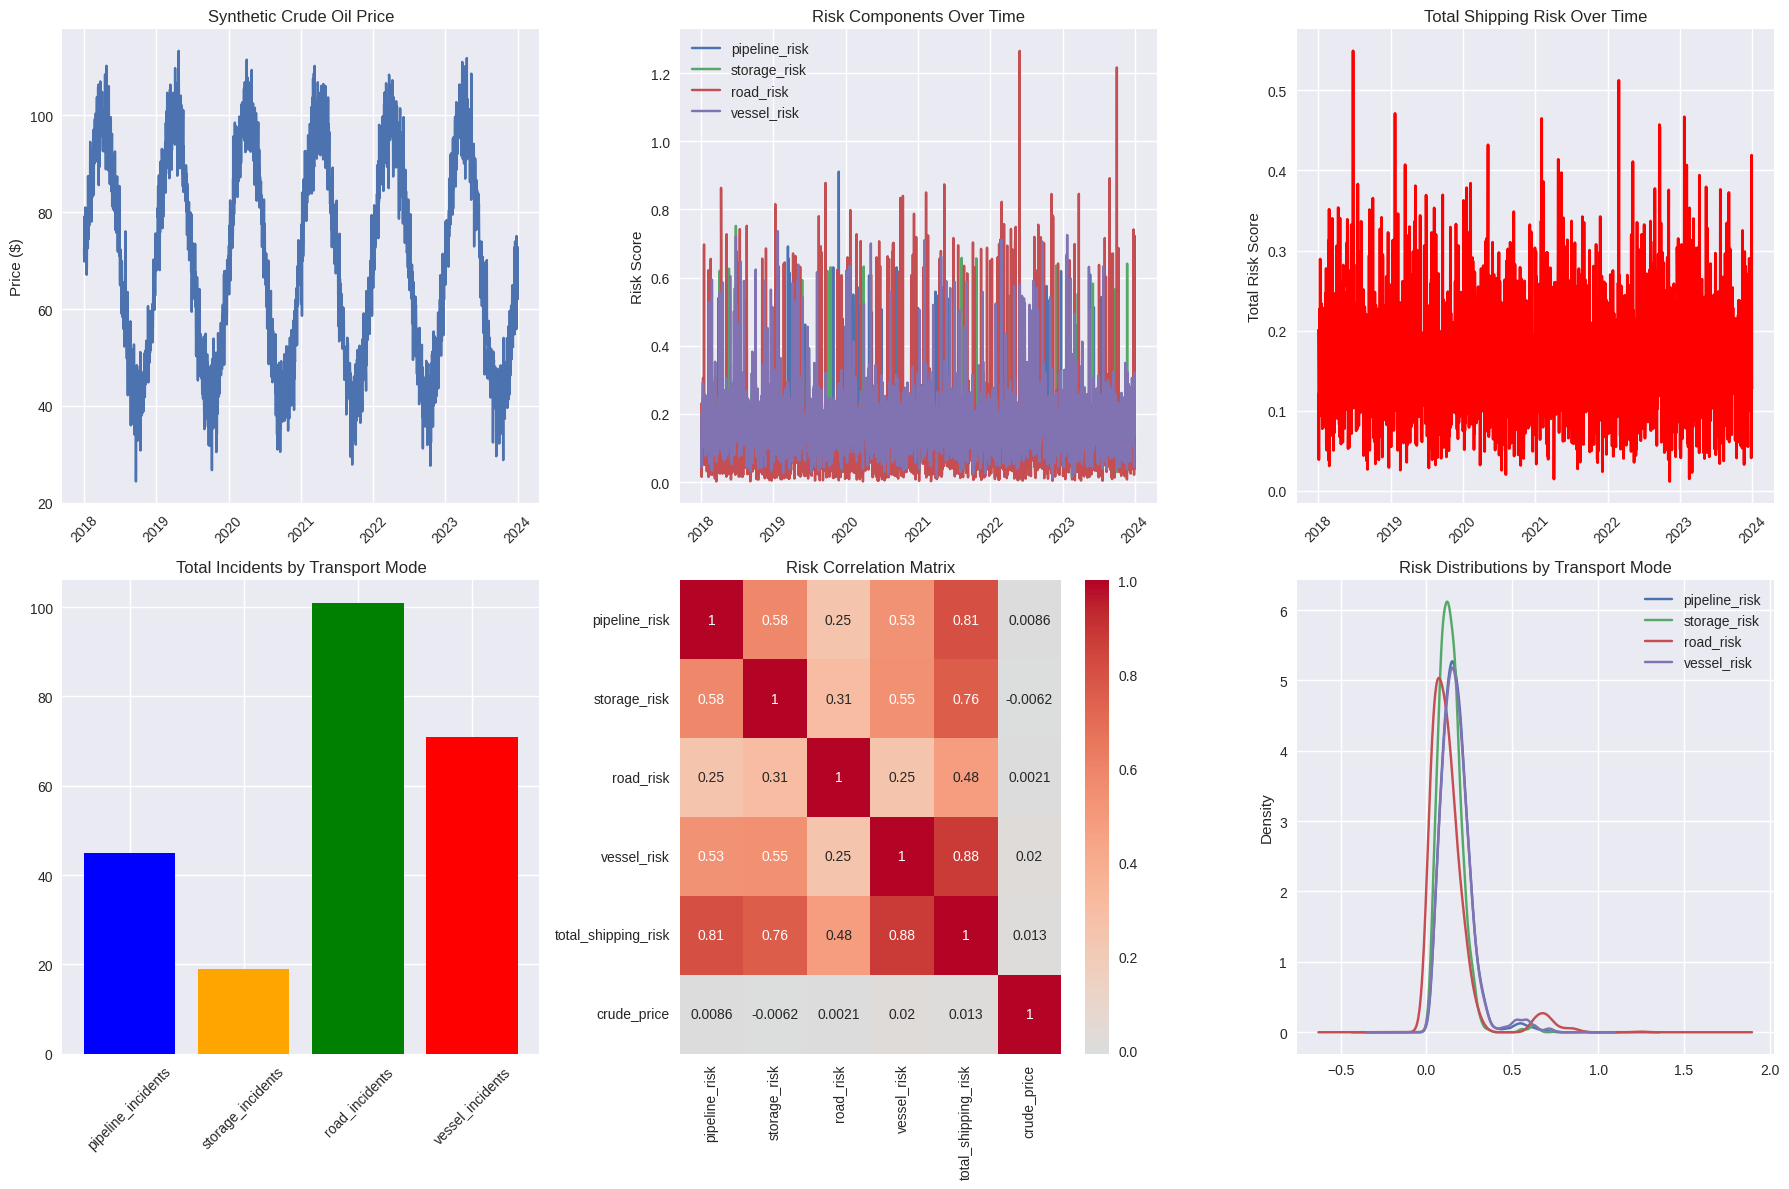

Statistical Summary of Risk Factors:
       pipeline_risk  storage_risk    road_risk  vessel_risk  \
count    2192.000000   2192.000000  2192.000000  2192.000000   
mean        0.172997      0.141144     0.135458     0.177741   
std         0.089862      0.074786     0.143833     0.099465   
min         0.012896      0.009597     0.001945     0.012896   
25%         0.113899      0.091615     0.055673     0.114105   
50%         0.161378      0.132639     0.103784     0.162121   
75%         0.213381      0.176191     0.159276     0.216184   
max         0.910673      0.751592     1.265072     0.736075   

       total_shipping_risk  
count          2192.000000  
mean              0.164770  
std               0.074961  
min               0.011346  
25%               0.109357  
50%               0.157166  
75%               0.208381  
max               0.549522  


In [ ]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Crude price trend
axes[0,0].plot(crude_data['date'], crude_data['crude_price'])
axes[0,0].set_title('Synthetic Crude Oil Price')
axes[0,0].set_ylabel('Price ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Risk components over time
risk_components = ['pipeline_risk', 'storage_risk', 'road_risk', 'vessel_risk']
for risk in risk_components:
    axes[0,1].plot(crude_data['date'], crude_data[risk], label=risk)
axes[0,1].set_title('Risk Components Over Time')
axes[0,1].set_ylabel('Risk Score')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Total shipping risk
axes[0,2].plot(crude_data['date'], crude_data['total_shipping_risk'], color='red', linewidth=2)
axes[0,2].set_title('Total Shipping Risk Over Time')
axes[0,2].set_ylabel('Total Risk Score')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Incident types
incidents = ['pipeline_incidents', 'storage_incidents', 'road_incidents', 'vessel_incidents']
incident_counts = [crude_data[inc].sum() for inc in incidents]
axes[1,0].bar(incidents, incident_counts, color=['blue', 'orange', 'green', 'red'])
axes[1,0].set_title('Total Incidents by Transport Mode')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Risk correlation heatmap
risk_corr = crude_data[['pipeline_risk', 'storage_risk', 'road_risk', 'vessel_risk',
                        'total_shipping_risk', 'crude_price']].corr()
sns.heatmap(risk_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Risk Correlation Matrix')

# 6. Risk distribution
crude_data[risk_components].plot.kde(ax=axes[1,2])
axes[1,2].set_title('Risk Distributions by Transport Mode')

plt.tight_layout()
plt.show()

# Statistical summary
print("Statistical Summary of Risk Factors:")
print(crude_data[risk_components + ['total_shipping_risk']].describe())

In [ ]:
# Advanced feature engineering for time series risk prediction
def create_advanced_features(df):
    df = df.copy()

    # Lag features for risk components
    for lag in [1, 7, 30]:  # 1 day, 1 week, 1 month lags
        for risk in risk_components:
            df[f'{risk}_lag_{lag}'] = df[risk].shift(lag)

    # Rolling statistics for risk factors
    for window in [7, 30, 90]:
        for risk in risk_components:
            df[f'{risk}_rolling_mean_{window}'] = df[risk].rolling(window=window).mean()
            df[f'{risk}_rolling_std_{window}'] = df[risk].rolling(window=window).std()
            df[f'{risk}_rolling_max_{window}'] = df[risk].rolling(window=window).max()

    # Price volatility features
    df['price_volatility_7d'] = df['crude_price'].rolling(window=7).std()
    df['price_volatility_30d'] = df['crude_price'].rolling(window=30).std()

    # Seasonal features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter

    # Risk momentum features
    for risk in risk_components:
        df[f'{risk}_momentum_7d'] = df[risk] - df[risk].shift(7)
        df[f'{risk}_momentum_30d'] = df[risk] - df[risk].shift(30)

    # Composite risk indicators
    df['infrastructure_risk'] = (df['pipeline_risk'] + df['storage_risk']) / 2
    df['transport_risk'] = (df['road_risk'] + df['vessel_risk']) / 2
    df['risk_ratio_infra_transport'] = df['infrastructure_risk'] / df['transport_risk']

    # Incident probability features
    for incident_col in ['pipeline_incidents', 'storage_incidents', 'road_incidents', 'vessel_incidents']:
        df[f'{incident_col}_prob_30d'] = df[incident_col].rolling(window=30).mean()

    return df

# Apply feature engineering
enhanced_data = create_advanced_features(crude_data)

# Drop initial rows with NaN values from rolling calculations
enhanced_data_clean = enhanced_data.dropna().reset_index(drop=True)

print(f"Original features: {len(crude_data.columns)}")
print(f"Enhanced features: {len(enhanced_data_clean.columns)}")
print(f"Final dataset shape: {enhanced_data_clean.shape}")

# Show new feature categories
new_features = [col for col in enhanced_data_clean.columns if col not in crude_data.columns]
print(f"\nNew engineered features: {len(new_features)}")
print("Feature categories created:")
feature_categories = {
    'Lag Features': [f for f in new_features if 'lag' in f],
    'Rolling Stats': [f for f in new_features if 'rolling' in f],
    'Volatility': [f for f in new_features if 'volatility' in f],
    'Seasonal': [f for f in new_features if any(x in f for x in ['day', 'month', 'quarter'])],
    'Momentum': [f for f in new_features if 'momentum' in f],
    'Composite': [f for f in new_features if any(x in f for x in ['infrastructure', 'transport', 'ratio'])]
}

for category, features in feature_categories.items():
    print(f"  {category}: {len(features)} features")

Original features: 17
Enhanced features: 85
Final dataset shape: (2103, 85)

New engineered features: 68
Feature categories created:
  Lag Features: 12 features
  Rolling Stats: 36 features
  Volatility: 2 features
  Seasonal: 3 features
  Momentum: 8 features
  Composite: 3 features


In [ ]:
# Prepare data for LSTM model
def prepare_lstm_data(df, target_col='total_shipping_risk', sequence_length=30, test_size=0.2):
    # Select features for modeling (excluding date and target)
    feature_columns = [col for col in df.columns if col not in ['date', target_col]
                       and not col.startswith('total_')]

    # Scale features
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X = scaler_X.fit_transform(df[feature_columns])
    y = scaler_y.fit_transform(df[[target_col]])

    # Create sequences for LSTM
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # Split into train/test
    split_idx = int(len(X_seq) * (1 - test_size))

    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y, feature_columns

# Prepare the data
sequence_length = 30
X_train, X_test, y_train, y_test, scaler_X, scaler_y, feature_columns = prepare_lstm_data(
    enhanced_data_clean, sequence_length=sequence_length
)

print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"\nFirst 10 features: {feature_columns[:10]}")

Training set shape: X_train (1658, 30, 83), y_train (1658, 1)
Test set shape: X_test (415, 30, 83), y_test (415, 1)
Number of features: 83

First 10 features: ['crude_price', 'pipeline_throughput', 'storage_utilization', 'road_transport_volume', 'vessel_rates', 'geopolitical_risk', 'weather_risk', 'pipeline_incidents', 'storage_incidents', 'road_incidents']


LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        26,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,501 (267.58 KB)

 Trainable params: 68,501 (267.58 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - loss: 0.0289 - mae: 0.1321 - val_loss: 0.0294 - val_mae: 0.1323
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0230 - mae: 0.1169 - val_loss: 0.0222 - val_mae: 0.1189
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0216 - mae: 0.1154 - val_loss: 0.0215 - val_mae: 0.1167
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0209 - mae: 0.1129 - val_loss: 0.0221 - val_mae: 0.1187
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0210 - mae: 0.1143 - val_loss: 0.0222 - val_mae: 0.1190
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0204 - mae: 0.1123 - val_loss: 0.0220 - val_mae: 0.1184
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0203 - mae: 0.1113 - val_loss: 0.0218 - val_mae: 0.1173
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0200 - mae: 0.1111 - val_loss: 0.0221 - val_mae: 0.1184
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 

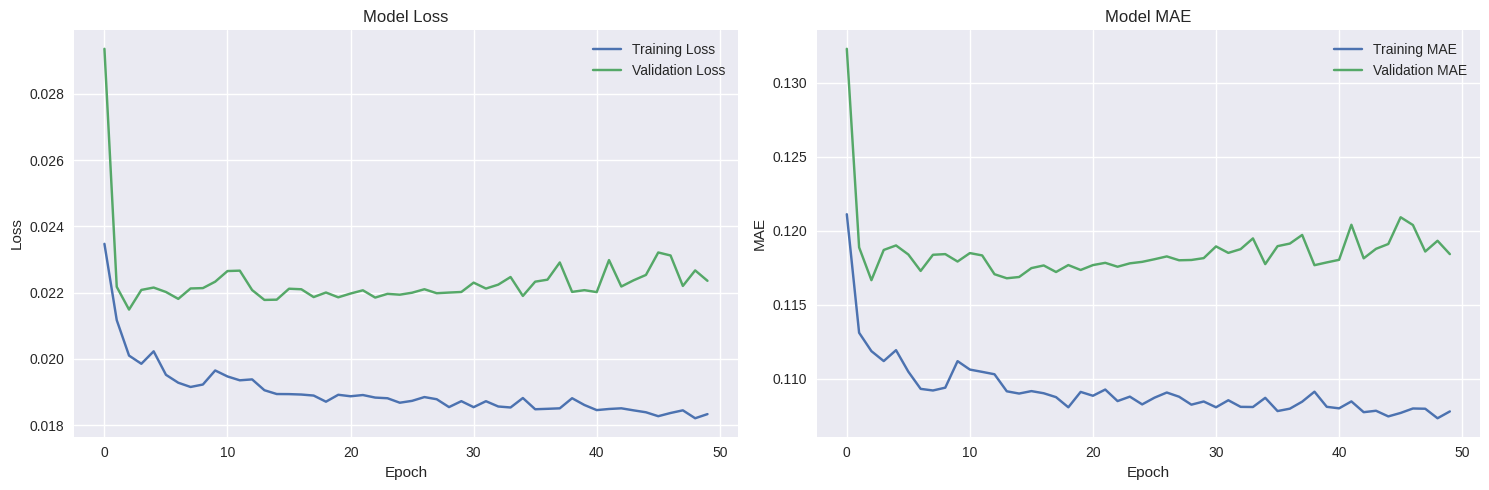

In [ ]:
# Build LSTM model
def build_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),

        LSTM(units=lstm_units, return_sequences=True),
        Dropout(dropout_rate),

        LSTM(units=lstm_units),
        Dropout(dropout_rate),

        Dense(units=25, activation='relu'),
        Dense(units=1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

# Build and display model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
print("LSTM Model Architecture:")
model.summary()

# Train the model
print("\nTraining LSTM model...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=False
)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Model Performance Metrics:
Mean Squared Error: 0.0059
Root Mean Squared Error: 0.0771
Mean Absolute Error: 0.0612


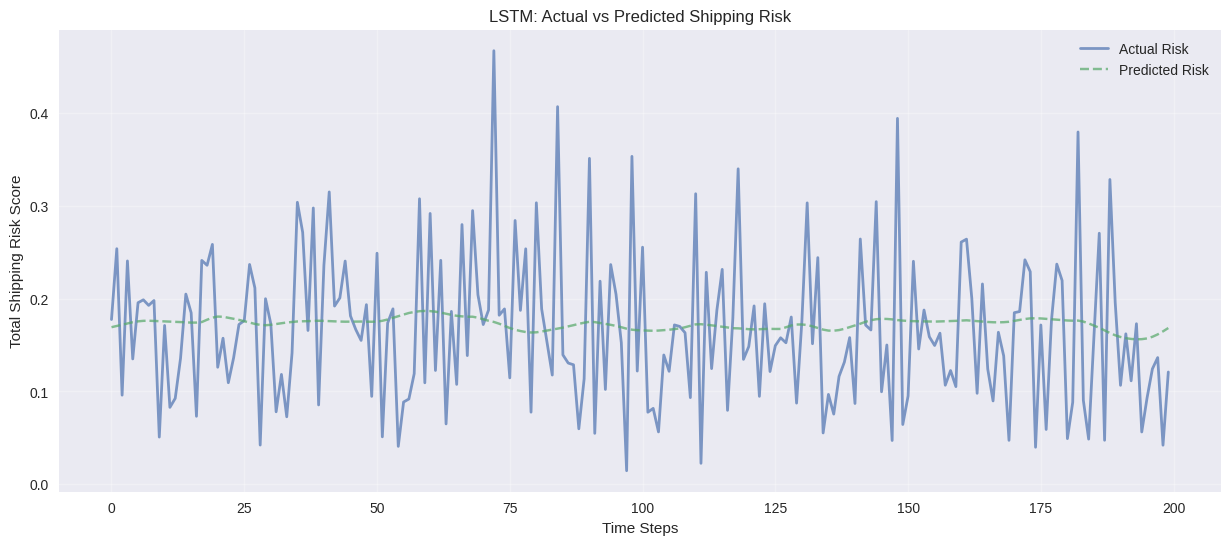


Top 15 Most Important Features (based on correlation with target):
  infrastructure_risk: 0.8795
  vessel_risk: 0.8788
  pipeline_risk: 0.8047
  transport_risk: 0.8011
  storage_risk: 0.7535
  weather_risk: 0.7059
  vessel_risk_momentum_7d: 0.6253
  vessel_risk_momentum_30d: 0.6002
  pipeline_risk_momentum_7d: 0.5884
  pipeline_risk_momentum_30d: 0.5514
  storage_risk_momentum_7d: 0.5345
  storage_risk_momentum_30d: 0.5144
  geopolitical_risk: 0.5131
  road_risk: 0.4744
  vessel_incidents: 0.3867


In [ ]:
# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

# Calculate metrics
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mse)

print(f"Model Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(15, 6))

# Select a subset for better visualization
plot_range = min(200, len(y_actual))
plt.plot(y_actual[:plot_range], label='Actual Risk', alpha=0.7, linewidth=2)
plt.plot(y_pred[:plot_range], label='Predicted Risk', alpha=0.7, linestyle='--')
plt.title('LSTM: Actual vs Predicted Shipping Risk')
plt.ylabel('Total Shipping Risk Score')
plt.xlabel('Time Steps')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance analysis (using permutation importance conceptually)
print("\nTop 15 Most Important Features (based on correlation with target):")
target_correlations = []
for feature in feature_columns:
    if feature in enhanced_data_clean.columns:
        corr = np.corrcoef(enhanced_data_clean[feature], enhanced_data_clean['total_shipping_risk'])[0,1]
        target_correlations.append((feature, abs(corr)))

# Sort by absolute correlation
target_correlations.sort(key=lambda x: x[1], reverse=True)
for feature, corr in target_correlations[:15]:
    print(f"  {feature}: {corr:.4f}")

Market Risk Analysis for Crude Oil Shipping:

95% Confidence Level:
  Historical VaR: -0.1759
  Parametric VaR: -0.1771
  CVaR: -0.2249
  Volatility: 0.1076

99% Confidence Level:
  Historical VaR: -0.2609
  Parametric VaR: -0.2504
  CVaR: -0.2960
  Volatility: 0.1076


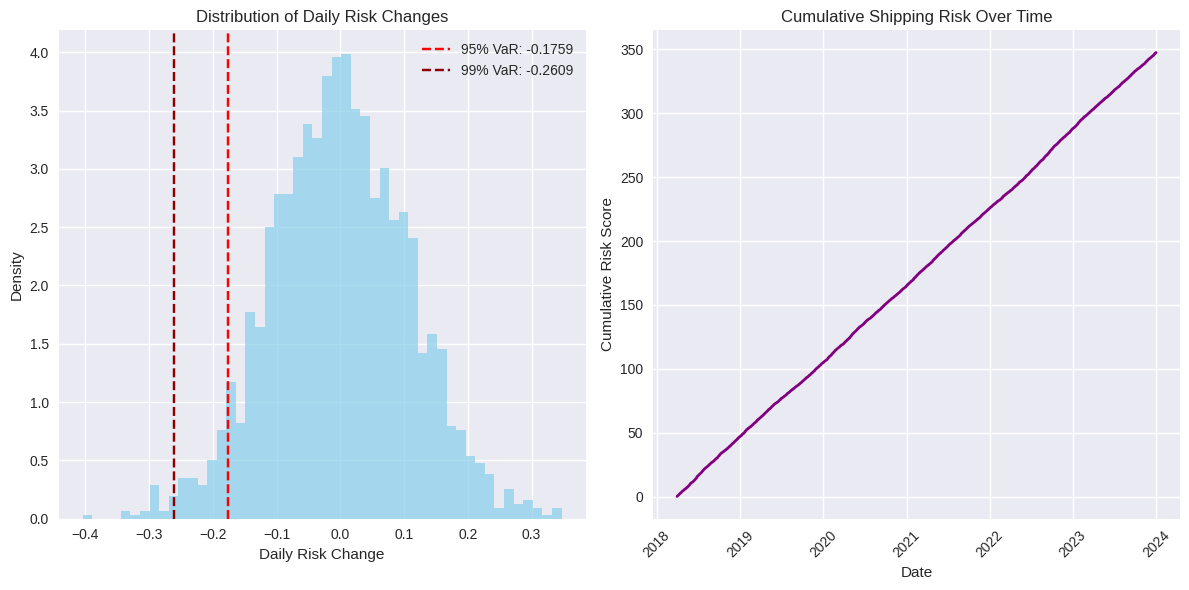

In [ ]:
# Market risk analysis for crude oil shipping
def calculate_market_risk_metrics(returns, confidence_level=0.95):
    """Calculate VaR and CVaR for risk returns"""
    # Historical VaR
    var_hist = np.percentile(returns, (1 - confidence_level) * 100)

    # Parametric VaR (assuming normal distribution)
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    var_param = stats.norm.ppf(1 - confidence_level, mean_return, std_return)

    # CVaR (Expected Shortfall)
    cvar = returns[returns <= var_hist].mean()

    return {
        'historical_var': var_hist,
        'parametric_var': var_param,
        'cvar': cvar,
        'volatility': std_return
    }

# Calculate daily risk changes as "returns"
risk_returns = np.diff(enhanced_data_clean['total_shipping_risk'])

# Calculate risk metrics
risk_metrics_95 = calculate_market_risk_metrics(risk_returns, 0.95)
risk_metrics_99 = calculate_market_risk_metrics(risk_returns, 0.99)

print("Market Risk Analysis for Crude Oil Shipping:")
print(f"\n95% Confidence Level:")
print(f"  Historical VaR: {risk_metrics_95['historical_var']:.4f}")
print(f"  Parametric VaR: {risk_metrics_95['parametric_var']:.4f}")
print(f"  CVaR: {risk_metrics_95['cvar']:.4f}")
print(f"  Volatility: {risk_metrics_95['volatility']:.4f}")

print(f"\n99% Confidence Level:")
print(f"  Historical VaR: {risk_metrics_99['historical_var']:.4f}")
print(f"  Parametric VaR: {risk_metrics_99['parametric_var']:.4f}")
print(f"  CVaR: {risk_metrics_99['cvar']:.4f}")
print(f"  Volatility: {risk_metrics_99['volatility']:.4f}")

# Plot risk distribution and VaR
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(risk_returns, bins=50, density=True, alpha=0.7, color='skyblue')
plt.axvline(risk_metrics_95['historical_var'], color='red', linestyle='--',
            label=f"95% VaR: {risk_metrics_95['historical_var']:.4f}")
plt.axvline(risk_metrics_99['historical_var'], color='darkred', linestyle='--',
            label=f"99% VaR: {risk_metrics_99['historical_var']:.4f}")
plt.title('Distribution of Daily Risk Changes')
plt.xlabel('Daily Risk Change')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
# Cumulative risk
cumulative_risk = enhanced_data_clean['total_shipping_risk'].cumsum()
plt.plot(enhanced_data_clean['date'], cumulative_risk, color='purple', linewidth=2)
plt.title('Cumulative Shipping Risk Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Risk Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Credit Risk Analysis:
Average Probability of Default: 0.3394 (33.94%)
Maximum Probability of Default: 0.5247 (52.47%)
Average Expected Credit Loss: $152,718.76
Total Portfolio ECL: $321,167,551.52


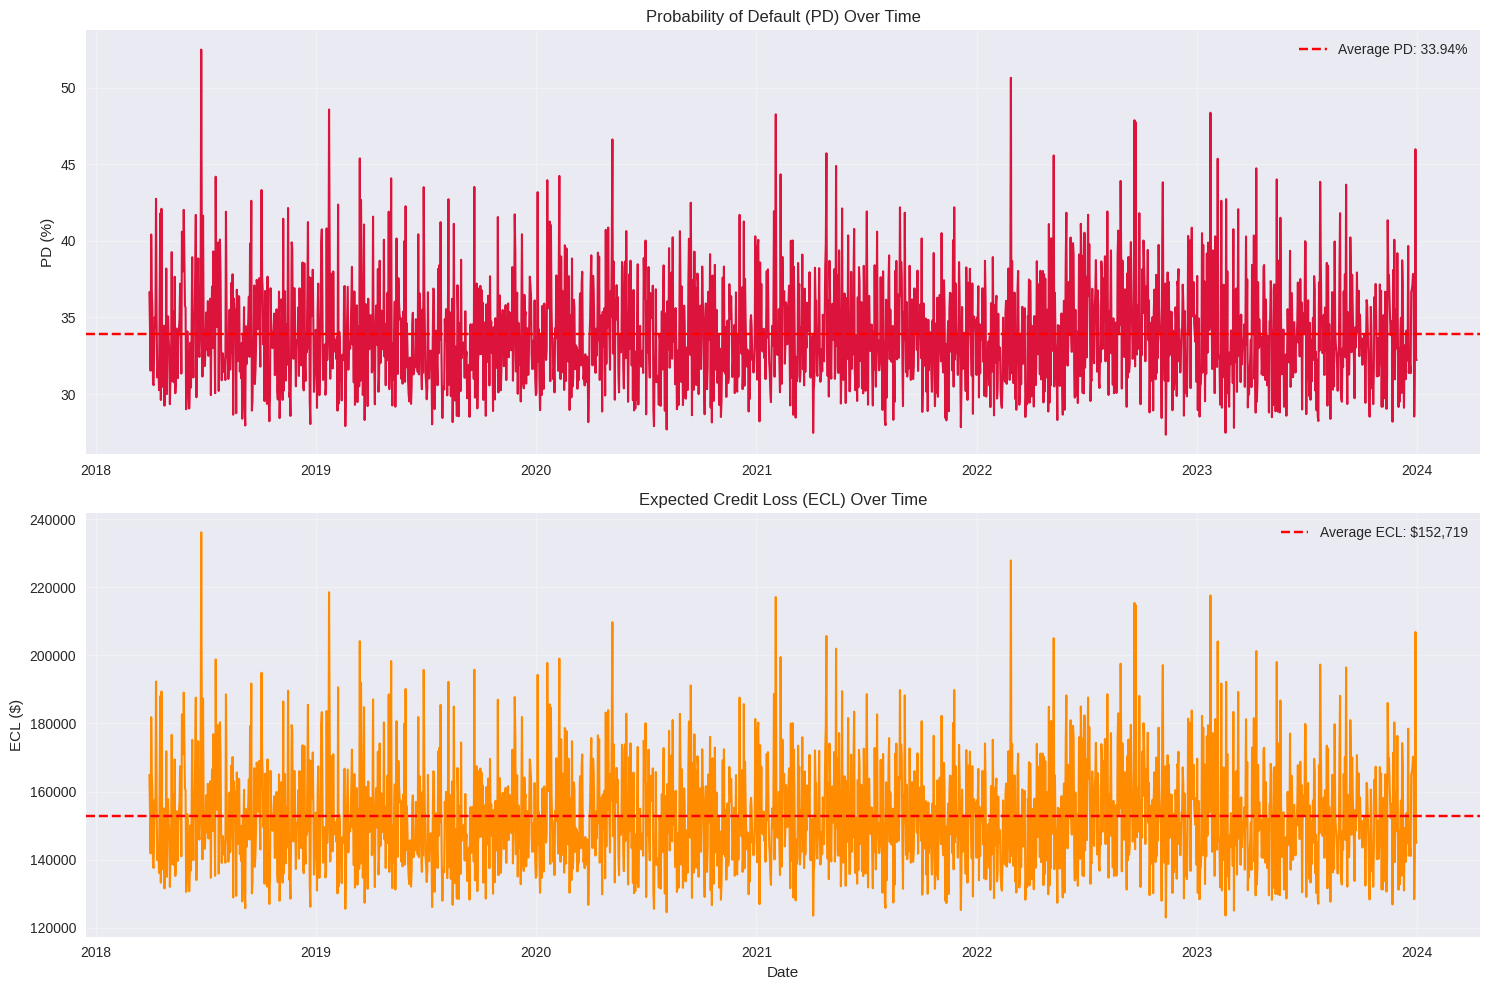


Risk Rating Distribution:
  B: 220 observations (10.5%)
  C: 1883 observations (89.5%)


In [ ]:
# PD and ECL analysis for shipping counterparties
def calculate_pd_ecl(risk_scores, lgd=0.45, ead=1000000):
    """
    Calculate Probability of Default and Expected Credit Loss
    LGD = Loss Given Default (45%)
    EAD = Exposure at Default ($1M)
    """
    # Convert risk scores to PD using logistic function
    # Higher risk scores -> higher PD
    pd_scores = 1 / (1 + np.exp(-2 * (risk_scores - 0.5)))  # Logistic transformation

    # Calculate ECL
    ecl_values = pd_scores * lgd * ead

    return pd_scores, ecl_values

# Calculate PD and ECL
pd_scores, ecl_values = calculate_pd_ecl(enhanced_data_clean['total_shipping_risk'])

# Add to dataframe
enhanced_data_clean['pd'] = pd_scores
enhanced_data_clean['ecl'] = ecl_values

print("Credit Risk Analysis:")
print(f"Average Probability of Default: {np.mean(pd_scores):.4f} ({np.mean(pd_scores)*100:.2f}%)")
print(f"Maximum Probability of Default: {np.max(pd_scores):.4f} ({np.max(pd_scores)*100:.2f}%)")
print(f"Average Expected Credit Loss: ${np.mean(ecl_values):,.2f}")
print(f"Total Portfolio ECL: ${np.sum(ecl_values):,.2f}")

# Plot PD and ECL over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# PD over time
ax1.plot(enhanced_data_clean['date'], enhanced_data_clean['pd'] * 100, color='crimson', linewidth=1.5)
ax1.axhline(y=np.mean(pd_scores)*100, color='red', linestyle='--',
            label=f'Average PD: {np.mean(pd_scores)*100:.2f}%')
ax1.set_title('Probability of Default (PD) Over Time')
ax1.set_ylabel('PD (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ECL over time
ax2.plot(enhanced_data_clean['date'], enhanced_data_clean['ecl'], color='darkorange', linewidth=1.5)
ax2.axhline(y=np.mean(ecl_values), color='red', linestyle='--',
            label=f'Average ECL: ${np.mean(ecl_values):,.0f}')
ax2.set_title('Expected Credit Loss (ECL) Over Time')
ax2.set_ylabel('ECL ($)')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Risk rating buckets based on PD
def assign_risk_ratings(pd_scores):
    ratings = []
    for pd in pd_scores:
        if pd < 0.01:
            ratings.append('AAA')
        elif pd < 0.02:
            ratings.append('AA')
        elif pd < 0.05:
            ratings.append('A')
        elif pd < 0.1:
            ratings.append('BBB')
        elif pd < 0.2:
            ratings.append('BB')
        elif pd < 0.3:
            ratings.append('B')
        else:
            ratings.append('C')
    return ratings

risk_ratings = assign_risk_ratings(pd_scores)
enhanced_data_clean['risk_rating'] = risk_ratings

print("\nRisk Rating Distribution:")
rating_counts = pd.Series(risk_ratings).value_counts().sort_index()
for rating, count in rating_counts.items():
    percentage = (count / len(risk_ratings)) * 100
    print(f"  {rating}: {count} observations ({percentage:.1f}%)")

Insurance Risk Analysis:
Average Insurance Premium: $101,487.40
Maximum Insurance Premium: $192,000.00
Average Expected Claims: $12,933.90
Loss Ratio (Claims/Premiums): 12.74%


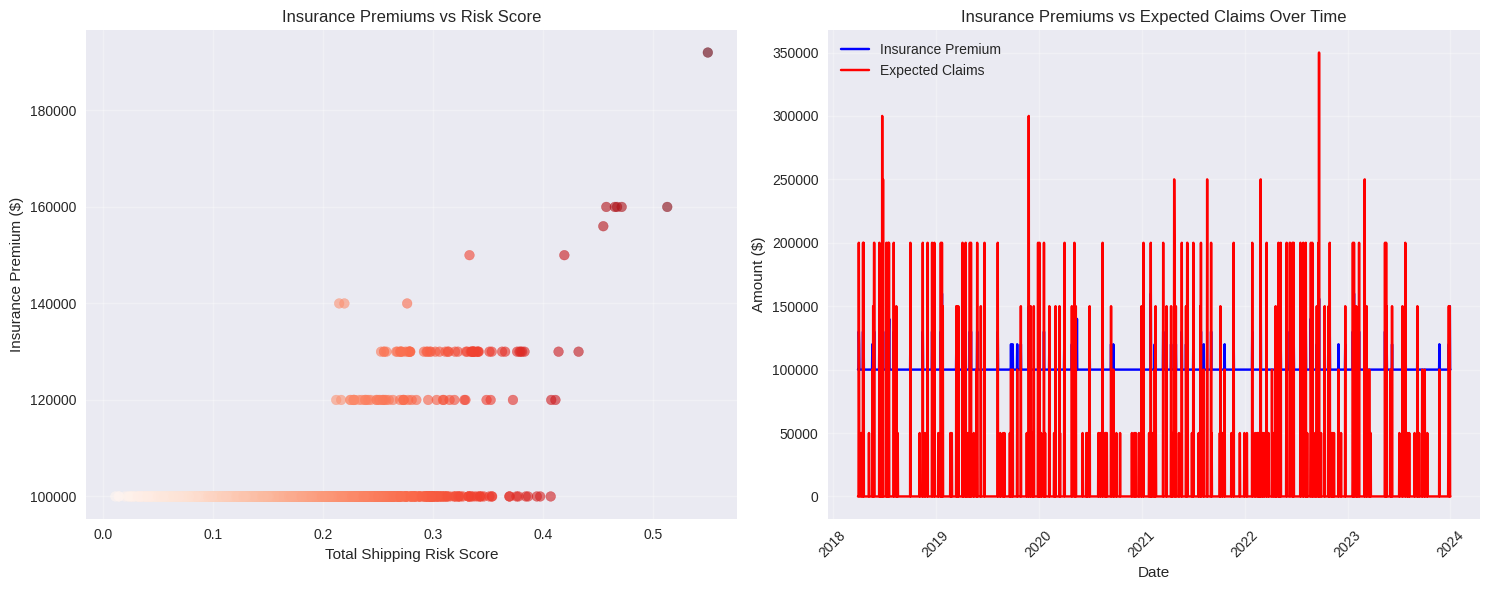

In [ ]:
# Insurance risk analysis and premium calculation
def calculate_insurance_premiums(risk_data, base_premium=100000):
    """
    Calculate insurance premiums based on risk factors
    """
    premiums = []

    for _, row in risk_data.iterrows():
        # Base premium adjustments based on risk factors
        risk_multiplier = 1.0

        # Pipeline risk adjustment
        if row['pipeline_risk'] > 0.7:
            risk_multiplier *= 1.5
        elif row['pipeline_risk'] > 0.5:
            risk_multiplier *= 1.2

        # Vessel risk adjustment
        if row['vessel_risk'] > 0.7:
            risk_multiplier *= 1.6
        elif row['vessel_risk'] > 0.5:
            risk_multiplier *= 1.3

        # Geopolitical risk adjustment
        if row['geopolitical_risk'] > 0.8:
            risk_multiplier *= 1.4

        # Storage risk adjustment
        if row['storage_risk'] > 0.6:
            risk_multiplier *= 1.2

        # Final premium calculation
        premium = base_premium * risk_multiplier
        premiums.append(premium)

    return premiums

# Calculate insurance premiums
insurance_premiums = calculate_insurance_premiums(enhanced_data_clean)
enhanced_data_clean['insurance_premium'] = insurance_premiums

# Calculate expected claims
def calculate_expected_claims(risk_data, severity_multiplier=500000):
    """
    Calculate expected insurance claims based on incident probabilities
    """
    expected_claims = []

    for _, row in risk_data.iterrows():
        # Total incident probability
        total_incident_prob = (row['pipeline_incidents'] * 0.3 +
                              row['storage_incidents'] * 0.2 +
                              row['road_incidents'] * 0.1 +
                              row['vessel_incidents'] * 0.4)

        # Expected claim amount
        expected_claim = total_incident_prob * severity_multiplier
        expected_claims.append(expected_claim)

    return expected_claims

expected_claims = calculate_expected_claims(enhanced_data_clean)
enhanced_data_clean['expected_claims'] = expected_claims

print("Insurance Risk Analysis:")
print(f"Average Insurance Premium: ${np.mean(insurance_premiums):,.2f}")
print(f"Maximum Insurance Premium: ${np.max(insurance_premiums):,.2f}")
print(f"Average Expected Claims: ${np.mean(expected_claims):,.2f}")
print(f"Loss Ratio (Claims/Premiums): {np.mean(expected_claims)/np.mean(insurance_premiums):.2%}")

# Plot insurance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Insurance premiums vs risk
ax1.scatter(enhanced_data_clean['total_shipping_risk'], enhanced_data_clean['insurance_premium'],
           alpha=0.6, c=enhanced_data_clean['total_shipping_risk'], cmap='Reds')
ax1.set_xlabel('Total Shipping Risk Score')
ax1.set_ylabel('Insurance Premium ($)')
ax1.set_title('Insurance Premiums vs Risk Score')
ax1.grid(True, alpha=0.3)

# Premiums and claims over time
ax2.plot(enhanced_data_clean['date'], enhanced_data_clean['insurance_premium'],
         label='Insurance Premium', color='blue')
ax2.plot(enhanced_data_clean['date'], enhanced_data_clean['expected_claims'],
         label='Expected Claims', color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Amount ($)')
ax2.set_title('Insurance Premiums vs Expected Claims Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Generating Comprehensive Risk Dashboard...


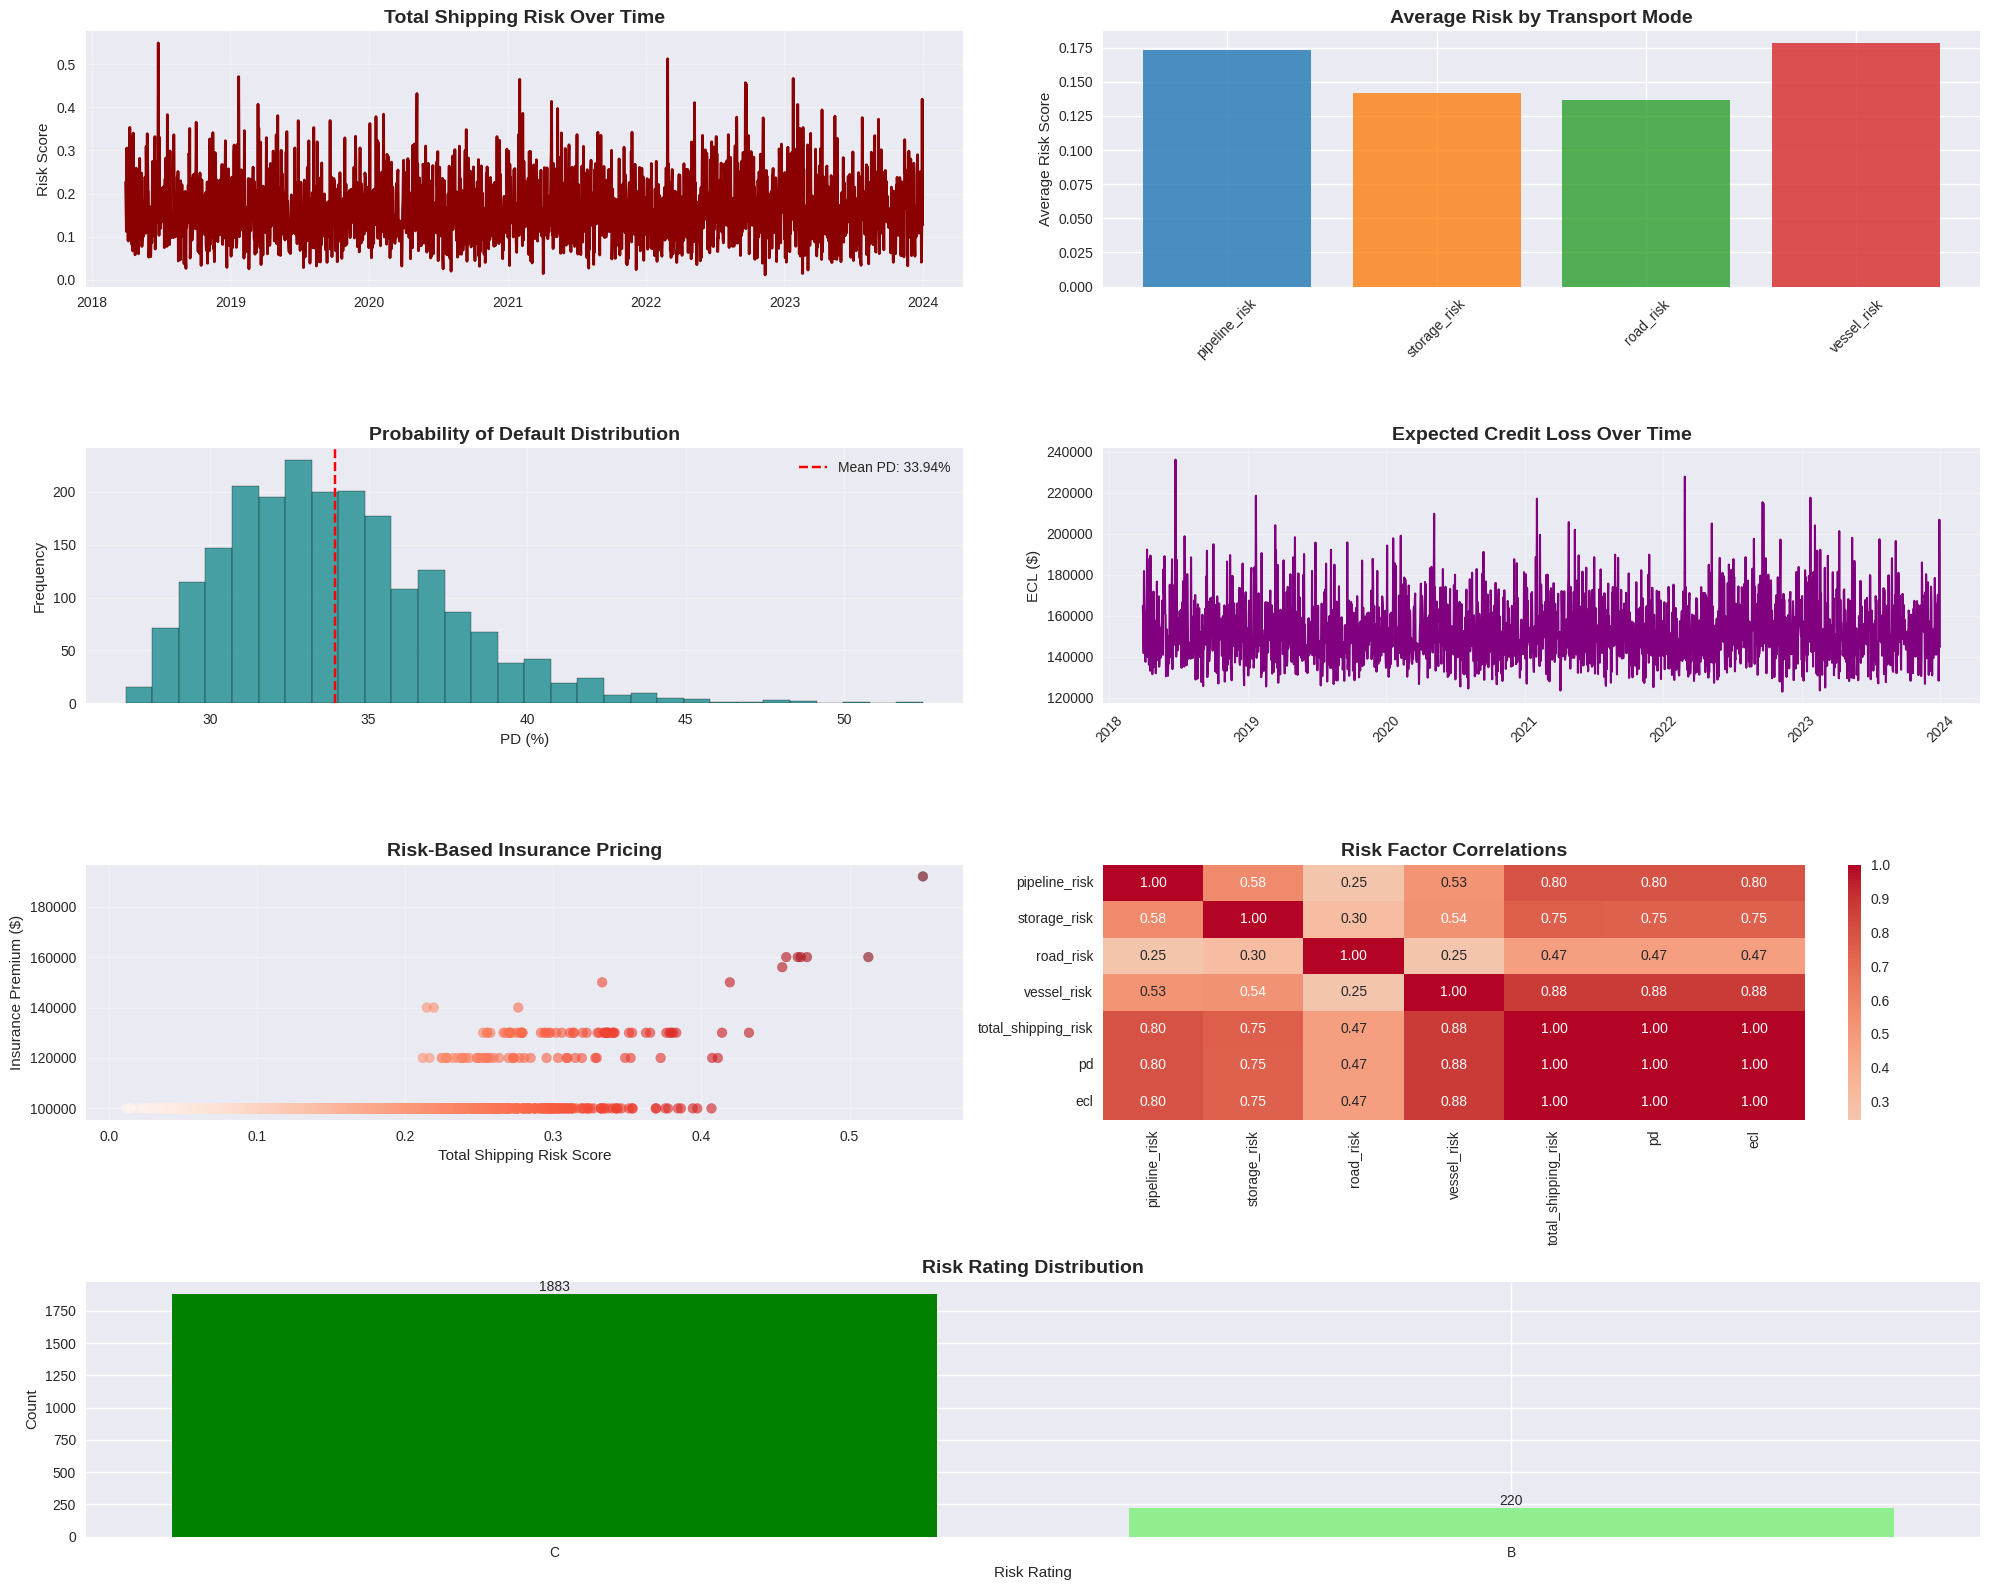


COMPREHENSIVE CRUDE OIL SHIPPING RISK SUMMARY
Analysis Period: 2018-03-31 to 2024-01-01
Total Observations: 2,103
Average Total Risk: 0.1652
Maximum Total Risk: 0.5495
Average PD: 0.3394 (33.94%)
Total ECL: $321,167,551.52
Average Insurance Premium: $101,487.40
LSTM Prediction RMSE: 0.0771


In [ ]:
# Create comprehensive risk dashboard
def create_risk_dashboard(data):
    fig = plt.figure(figsize=(20, 16))

    # Define grid
    gs = fig.add_gridspec(4, 4)

    # 1. Total Risk Over Time (top row, full width)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(data['date'], data['total_shipping_risk'], linewidth=2, color='darkred')
    ax1.set_title('Total Shipping Risk Over Time', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Risk Score')
    ax1.grid(True, alpha=0.3)

    # 2. Risk Components
    ax2 = fig.add_subplot(gs[0, 2:])
    risk_components = ['pipeline_risk', 'storage_risk', 'road_risk', 'vessel_risk']
    component_means = [data[risk].mean() for risk in risk_components]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = ax2.bar(risk_components, component_means, color=colors, alpha=0.8)
    ax2.set_title('Average Risk by Transport Mode', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Risk Score')
    plt.sca(ax2)
    plt.xticks(rotation=45)

    # 3. PD Distribution
    ax3 = fig.add_subplot(gs[1, :2])
    ax3.hist(data['pd'] * 100, bins=30, alpha=0.7, color='teal', edgecolor='black')
    ax3.axvline(data['pd'].mean() * 100, color='red', linestyle='--',
                label=f'Mean PD: {data["pd"].mean()*100:.2f}%')
    ax3.set_title('Probability of Default Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('PD (%)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. ECL Over Time
    ax4 = fig.add_subplot(gs[1, 2:])
    ax4.plot(data['date'], data['ecl'], color='purple', linewidth=1.5)
    ax4.set_title('Expected Credit Loss Over Time', fontsize=14, fontweight='bold')
    ax4.set_ylabel('ECL ($)')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)

    # 5. Insurance Analysis
    ax5 = fig.add_subplot(gs[2, :2])
    ax5.scatter(data['total_shipping_risk'], data['insurance_premium'],
               alpha=0.6, c=data['total_shipping_risk'], cmap='Reds')
    ax5.set_xlabel('Total Shipping Risk Score')
    ax5.set_ylabel('Insurance Premium ($)')
    ax5.set_title('Risk-Based Insurance Pricing', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)

    # 6. Risk Correlation Heatmap
    ax6 = fig.add_subplot(gs[2, 2:])
    corr_matrix = data[['pipeline_risk', 'storage_risk', 'road_risk', 'vessel_risk',
                       'total_shipping_risk', 'pd', 'ecl']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax6, fmt='.2f')
    ax6.set_title('Risk Factor Correlations', fontsize=14, fontweight='bold')

    # 7. Risk Rating Distribution
    ax7 = fig.add_subplot(gs[3, :])
    rating_counts = data['risk_rating'].value_counts()
    colors = ['green', 'lightgreen', 'yellow', 'orange', 'darkorange', 'red', 'darkred']
    bars = ax7.bar(rating_counts.index, rating_counts.values, color=colors[:len(rating_counts)])
    ax7.set_title('Risk Rating Distribution', fontsize=14, fontweight='bold')
    ax7.set_xlabel('Risk Rating')
    ax7.set_ylabel('Count')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Display comprehensive dashboard
print("Generating Comprehensive Risk Dashboard...")
create_risk_dashboard(enhanced_data_clean)

# Final risk summary
print("\n" + "="*60)
print("COMPREHENSIVE CRUDE OIL SHIPPING RISK SUMMARY")
print("="*60)
print(f"Analysis Period: {enhanced_data_clean['date'].min().date()} to {enhanced_data_clean['date'].max().date()}")
print(f"Total Observations: {len(enhanced_data_clean):,}")

risk_summary = {
    'Average Total Risk': enhanced_data_clean['total_shipping_risk'].mean(),
    'Maximum Total Risk': enhanced_data_clean['total_shipping_risk'].max(),
    'Average PD': enhanced_data_clean['pd'].mean(),
    'Total ECL': enhanced_data_clean['ecl'].sum(),
    'Average Insurance Premium': enhanced_data_clean['insurance_premium'].mean(),
    'LSTM Prediction RMSE': rmse
}

for metric, value in risk_summary.items():
    if 'ECL' in metric or 'Premium' in metric:
        print(f"{metric}: ${value:,.2f}")
    elif 'PD' in metric:
        print(f"{metric}: {value:.4f} ({value*100:.2f}%)")
    elif 'RMSE' in metric:
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value:.4f}")

print("="*60)

In [ ]:
# Risk forecasting and scenario analysis
def forecast_risk_scenarios(model, last_sequence, scaler_X, scaler_y, periods=30, n_scenarios=5):
    """Generate multiple risk scenarios using Monte Carlo simulation"""
    forecasts = []

    for scenario in range(n_scenarios):
        current_sequence = last_sequence.copy()
        scenario_forecast = []

        for _ in range(periods):
            # Add small noise for scenario variation
            noisy_sequence = current_sequence + np.random.normal(0, 0.01, current_sequence.shape)

            # Predict next step
            next_pred_scaled = model.predict(noisy_sequence[-1:], verbose=0)
            next_pred = scaler_y.inverse_transform(next_pred_scaled)[0][0]
            scenario_forecast.append(next_pred)

            # Update sequence for next prediction (using simulated values)
            new_row = noisy_sequence[-1, 1:, :]  # Remove first row
            new_row = np.vstack([new_row, noisy_sequence[-1, -1:, :]])  # Add prediction
            current_sequence = np.array([new_row])

        forecasts.append(scenario_forecast)

    return forecasts

# Get the last sequence for forecasting
last_sequence = X_test[-1:]
forecast_periods = 30

# Generate scenarios
risk_scenarios = forecast_risk_scenarios(model, last_sequence, scaler_X, scaler_y,
                                        periods=forecast_periods, n_scenarios=5)

# Plot risk forecasts
plt.figure(figsize=(15, 8))

# Historical data
historical_dates = enhanced_data_clean['date'][-100:]
historical_risk = enhanced_data_clean['total_shipping_risk'][-100:]

plt.plot(historical_dates, historical_risk, label='Historical Risk', color='black', linewidth=2)

# Forecast dates
last_date = enhanced_data_clean['date'].iloc[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, forecast_periods + 1)]

# Plot scenarios
colors = ['red', 'orange', 'green', 'blue', 'purple']
for i, scenario in enumerate(risk_scenarios):
    plt.plot(forecast_dates, scenario, label=f'Scenario {i+1}',
             color=colors[i], alpha=0.7, linestyle='--')

plt.title('Crude Oil Shipping Risk Forecast - Multiple Scenarios', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Total Shipping Risk Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scenario analysis summary
print("Risk Forecast Scenario Analysis:")
for i, scenario in enumerate(risk_scenarios):
    avg_risk = np.mean(scenario)
    max_risk = np.max(scenario)
    print(f"Scenario {i+1}: Average Risk = {avg_risk:.4f}, Max Risk = {max_risk:.4f}")

# Calculate Value at Risk for forecasts
all_forecast_values = np.array(risk_scenarios).flatten()
forecast_var_95 = np.percentile(all_forecast_values, 5)  # 5th percentile for worst-case
forecast_var_99 = np.percentile(all_forecast_values, 1)  # 1st percentile for extreme worst-case

print(f"\nForecast Risk Measures:")
print(f"95% VaR (Worst-case scenario): {forecast_var_95:.4f}")
print(f"99% VaR (Extreme worst-case): {forecast_var_99:.4f}")
print(f"Average Forecast Risk: {np.mean(all_forecast_values):.4f}")